## Imports

In [1]:
# Std imports
import operator
from itertools import combinations
# read data
import pandas as pd
# preprocessing
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
# SVD
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from gensim.models import KeyedVectors
# Visualization
import matplotlib.pyplot as plt

## Read Data

In [2]:
# Enter a txt filename, E.g., mental-health.txt
filename = ""

fp = open(filename, 'r')

data = fp.readlines()

fp.close()

In [3]:
# Converting paragraphs to sentences
sentences = []

for d in data:
    sentence_list = nltk.sent_tokenize(d)
    sentences.extend(sentence_list)

len(sentences)

142

In [4]:
dict = {'text': sentences}

df = pd.DataFrame(dict)
print(df.head(), df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142 entries, 0 to 141
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    142 non-null    object
dtypes: object(1)
memory usage: 1.2+ KB
                               text
0          Social anxiety disorder.
1    Obsessive compulsive disorder.
2        Major depressive disorder.
3  Borderline personality disorder.
4   Post-traumatic stress disorder. None


## Preprocess Text
### 1. Remove punctuation (,/.!'?")
### 2. Convert to lower case
### 3. Text tokenization
### 4. Remove stop words
### 5. Text leminization
### 6. Bag of words

In [5]:
# remove punctuations
df['processed_text'] = df['text'].str.replace('[^\w\s]','')

print(df['processed_text'])

0                                Social anxiety disorder
1                          Obsessive compulsive disorder
2                              Major depressive disorder
3                        Borderline personality disorder
4                          Posttraumatic stress disorder
                             ...                        
137    Finally transdiagnostic research and practice ...
138    Coordinated efforts are required to ensure tha...
139    In particular our trials need to be designed t...
140    Overall we need to better reflect the personal...
141    Transdiagnostic approaches potentially provide...
Name: processed_text, Length: 142, dtype: object


In [6]:
# Remove stopwords
stop_words = set(nltk.corpus.stopwords.words('english'))

df['processed_text'] = df['processed_text'].apply(lambda x: ' '.join([word for word in x.lower().split() if word not in stop_words]))
df.head()

,text,processed_text
0,Social anxiety disorder.,social anxiety disorder
1,Obsessive compulsive disorder.,obsessive compulsive disorder
2,Major depressive disorder.,major depressive disorder
3,Borderline personality disorder.,borderline personality disorder
4,Post-traumatic stress disorder.,posttraumatic stress disorder


In [7]:
# from SKLearn docs
# class for tokenizing and lemmatizing
class LemmaTokenizer():
    def __init__(self):
        self.wnl = nltk.stem.WordNetLemmatizer()
        
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in nltk.word_tokenize(doc)]

In [8]:
# TfIDFVectorizer will calculate the TfIDF weights that can be fed into the LSA Model.
vect = TfidfVectorizer(analyzer='word', 
                       tokenizer=LemmaTokenizer(), 
                       lowercase='True',
                       max_df = 0.5,
                       smooth_idf=True)

x = vect.fit_transform(df['processed_text'])
x.shape

(142, 974)

## Topic Modelling - LSA

### Evaluation (Topic Coherence - TC-W2V)

In [9]:
## Load pretrained Word2Vec model from file
# It is a pretrained Word2Vec model. It was trained on Google news dataset. Since the input dataset is an article on # health issues and news usuallly talk about them, the news model would be suitable for the dataset.
# To download the below model, please visit: https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
w2v_model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

In [10]:
# http://derekgreene.com/slides/topic-modelling-with-scikitlearn.pdf
def get_mean_coherence(w2v_model, term_rankings):
    overall_coherence = 0.0
    
    for topic_index in range(len(term_rankings)):
        # check each pair of terms
        pair_scores = []
        
        for pair in combinations( term_rankings[topic_index], 2 ):
            try:
                pair_scores.append( w2v_model.similarity(pair[0], pair[1]) )
            except KeyError:
                continue
        
        # get the mean for all pairs in this topic
        topic_score = sum(pair_scores) / len(pair_scores)
        overall_coherence += topic_score
    
    # mean coherence across all topics
    mean_coherence = overall_coherence / len(term_rankings)

    return mean_coherence

### Hyperparameters tuning

In [11]:
# Returns the n_top_words words for each topic as a list of list
def get_term_rankings(vect, svd, n_top_words):
    term_rankings = []

    # Appending n_top_words of each topic to term_rankings
    terms = vect.get_feature_names()
    for topic_idx, topic in enumerate(svd.components_):
        top_terms = [terms[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        term_rankings.append(top_terms)

    return term_rankings

In [12]:
# Function to print the top n_top_words for each topic
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)

In [13]:
# Grid Search to find best parameters for LSA model
topic_count = [2, 3, 4, 5, 6, 7, 8, 9, 10]
hyperparameters_score_dict = {}

for ntopic in topic_count:
    print("Topics: ", ntopic)
    svd = TruncatedSVD(n_components=ntopic, algorithm="randomized")
    svd.fit(x)
    feature_names = vect.get_feature_names()
    term_rankings = get_term_rankings(vect, svd, 10)
    mu_coherence = get_mean_coherence(w2v_model, term_rankings)
    hyperparameters_score_dict[ntopic] = round(mu_coherence, 4)
    print(mu_coherence)

Topics:  2
0.17825785818018225
Topics:  3
0.1401333979167113
Topics:  4
0.13965057526883257
Topics:  5
0.15815332830624862
Topics:  6
0.15181779327017633
Topics:  7
0.15073007720373696
Topics:  8
0.1358580873493338
Topics:  9
0.1459110670632681
Topics:  10
0.14123182120766226


In [14]:
# Retrieve best parameters
best_n_topic = max(hyperparameters_score_dict.items(), key=operator.itemgetter(1))[0]
best_n_topic

2

In [15]:
# SVD modeling - SVD with best parameters
svd_model = TruncatedSVD(n_components=best_n_topic, algorithm='randomized')

svd_model.fit(x)

TruncatedSVD()

In [16]:
# Matrix decomposition
U = svd_model.transform(x)
S = svd_model.singular_values_
V = svd_model.components_
 
print('U,Sigma,V', U,S,V)

U,Sigma,V [[ 2.29510691e-01  6.45903788e-01]
 [ 8.63343685e-02  2.21356982e-01]
 [ 1.27120430e-01  3.23376559e-01]
 [ 1.22736128e-01  3.05693164e-01]
 [ 1.21188022e-01  2.85700307e-01]
 [ 2.25835629e-01  6.16782837e-01]
 [ 2.83365165e-01 -1.35568122e-01]
 [ 1.21107728e-01  4.89394022e-02]
 [ 1.10234292e-01  3.63416843e-02]
 [ 4.89508045e-02  9.38250437e-02]
 [ 1.32556822e-01  3.85568181e-01]
 [ 2.95555694e-01  5.22283023e-02]
 [ 2.59035442e-01  4.46283632e-02]
 [ 1.50903999e-01 -3.13723912e-02]
 [ 1.76662725e-01 -2.85797419e-02]
 [ 2.50968860e-01 -1.22269826e-02]
 [ 2.74044071e-01 -1.38801641e-01]
 [ 1.43859000e-01 -5.98953781e-02]
 [ 1.27891171e-01 -2.64041041e-02]
 [ 2.77783187e-01 -1.77581698e-01]
 [ 2.06160619e-01  1.78073160e-01]
 [ 2.64580371e-01  2.55106922e-01]
 [ 3.33582513e-01 -1.50627694e-01]
 [ 1.36526830e-01 -8.12118829e-02]
 [ 1.28430110e-01 -1.16322951e-01]
 [-3.80559021e-05 -3.74014075e-04]
 [ 2.31385177e-01  5.09197084e-02]
 [ 2.16049896e-01 -7.33684003e-02]
 [ 1.52479

In [17]:
print("\nTopics in Best LSA model:")
n_top_words = 10
terms = vect.get_feature_names()
print_top_words(svd_model, terms, n_top_words)


Topics in Best LSA model:
Topic #0: health mental disorder problem treatment approach transdiagnostic system research anxiety
Topic #1: disorder anxiety social generalised personality depressive major mood example depression


## Visualizations

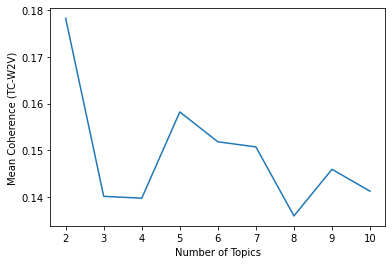

In [18]:
fig, ax = plt.subplots()
ax.plot(topic_count, list(hyperparameters_score_dict.values()))
plt.xlabel('Number of Topics')
plt.ylabel('Mean Coherence (TC-W2V)')
fig.show()

In [25]:
# Save figure
fig.savefig("lsa_ntopics_tuning.svg")